In [1]:
import cvflow as cf
import laneFindingPipeline
%matplotlib inline

In [2]:
allFrames = laneFindingPipeline.utils.loadFrames(maxFrames=32)

HBox(children=(IntProgress(value=0, description='load project: ', max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load challenge: ', max=32), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load harder_challenge: ', max=32), HTML(value='')))

In [3]:
frame = allFrames['project'][-1]

# Development of a pipeline for identifying lane-marking pixels

## A simple pipeline

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))

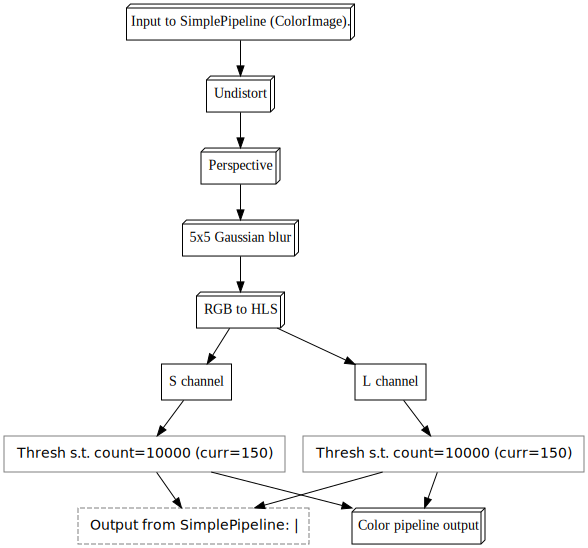

In [8]:
pipeline = cf.SimplePipeline()
pipeline.getThisSubgraph()

This pipeline is fairly simple--we use the saturation channel to detect the yellow left line, and the lightness channel to detect the white right line.

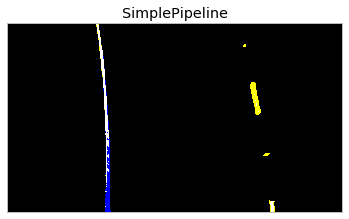

In [5]:
linePixels = pipeline(frame)
color = pipeline.colorOutput.value
laneFindingPipeline.utils.show(color, title=pipeline);

To find only relevant pixels in each 

In [6]:
pipeline = cf.SimplePipeline()
nd = pipeline.draw(outType='NodeDigraph')
for member in nd._subgraphs['cluster KEY'][0][-1]:
    pass#print(member.containingMultistepOp)

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))

In [7]:
# Kind = type(self)
# subgraphsForThisKind = []
# for subgraphsForFocalKind in nd._subgraphs.values():
#     subgraph = subgraphsForFocalKind[0]
#     name, gvd, nx, members = subgraph
#     containers = [
#         cont for cont in 
#         [getattr(member, 'containingMultistepOp', None) for member in members]
#         if cont
#     ]
#     if len(containers) > 0 and all([cont is self for cont in containers]):
#         subgraphsForThisKind.append(subgraph)
# subgraphsForThisKind

# Future work
* Use a predictive model for the evolution of the lane lines--e.g., fit a polynomial in time.